In [1]:
import os
import sys
import torch
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

current_folder = globals()['_dh'][0]
print(current_folder)
os.chdir(os.path.join(current_folder, '..'))

from utils.eval_utils import load_tiff, visualise_images

from backbone.flimngo_net import GetModel
from tqdm import tqdm

C:\Users\User\Desktop\PhD\Projects\dl_flim\FLIMngo\demo_notebooks


In [2]:
# load cuda if available, if not choose cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Data Preprocessing

- Data is loaded from `.tiff` files with dimensions `(x, y, t)`.
- The time dimension has **already been normalised** to a range between 0 and 1.
- **Background** regions in the images have **aready been masked**.

This notebook focuses on predicting fluorescence lifetimes from experimental images acquired on different experiments.  
Two datasets are analysed:  

1. **Standard Photon Counts**:  
   The experimental images where each pixel has at least 100 photon counts.  

2. **Reduced Photon Counts**:  
   A dataset derived from the experimental images by randomly subsampling the photon counts, reducing them to 10–100 photons per pixel.  

To ensure consistency, identical masks have been applied to both the `Standard Photon Counts` and `Reduced Photon Counts` datasets, ensuring the same regions are analysed. For more further details on this analysis, please refer to our manuscript.


In [3]:
dir = 'sample_data/experimental/'
bin_width = 0.09765625114122045 # experimental bin width in ns 

In [4]:
data_dict = {} # initiate dictionary to save data

filenames_standard = os.listdir(os.path.join(dir, 'raw_standard_counts')) # get list of filenames, names should be identical for "reduced" photon count data

for filename in filenames_standard:

    # laod the .tif files containing the data with the "standard" and "reduced" photon counts
    raw_data_standard = load_tiff(dir=os.path.join(dir, 'raw_standard_counts'), filename=filename)
    raw_data_reduced = load_tiff(dir=os.path.join(dir, 'raw_reduced_counts'), filename=filename)

    # remove .tif extension for the dictionary key
    file_key = os.path.splitext(filename)[0]
    
    # store everything into the dictionary with the file names as the keys
    data_dict[file_key] = {
        'raw_data_standard': raw_data_standard,
        'raw_data_reduced': raw_data_reduced,
    }

In [5]:
data_dict.keys()

dict_keys(['celegans_gfp_fus', 'cos7_microtubules', 'HEK_nucleus_gfp_fus', 'rhodamine_6G'])

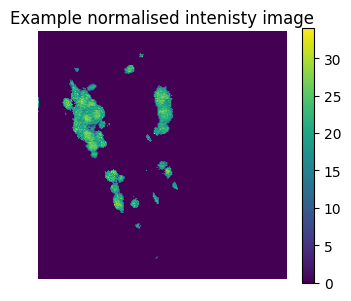

In [6]:
# visualise example intenisty image, which has already been normalised
# this will ensure that images have been correctly loaded
plt.figure(figsize=(4, 3.3))  # set the figure size
plt.imshow(data_dict['celegans_gfp_fus']['raw_data_standard'].sum(0))  # display the summed image (i.e. intensity)
plt.title("Example normalised intenisty image")
plt.colorbar() 
plt.axis('off')
plt.show()

In [7]:
time = np.arange(0, 256) * bin_width # get time axis from bin width

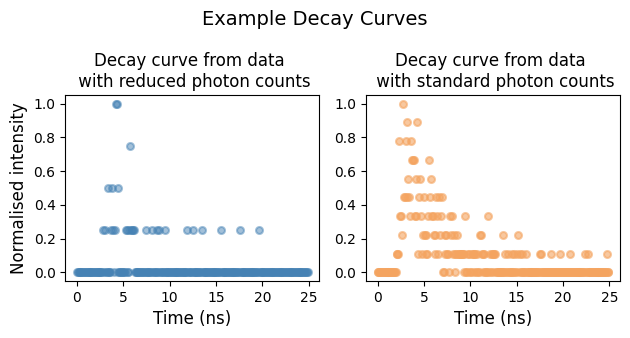

In [8]:
# Visualise the decay curve of the same pixel in the standard and reduced photon data
sample = data_dict['rhodamine_6G'] # select sample 
fig, axes = plt.subplots(1, 2, figsize=(6.4, 3.4)) 

fig.suptitle("Example Decay Curves", fontsize=14)

# plot a normalised decay curve from the reduced photon image
axes[0].scatter(time, sample['raw_data_reduced'][:, 20, 20], 
                c='steelblue', s=25, alpha=0.5, linewidth= 1.5)
axes[0].set_title(f'Decay curve from data \n with reduced photon counts')
axes[0].set_ylabel("Normalised intensity", fontsize=12)  # Add y-axis label

# plot the saem normalised decay curve in the standard photon image
axes[1].scatter(time, sample['raw_data_standard'][:, 20, 20], 
                c='sandybrown', s=25, alpha=0.6, linewidth= 1.5)
axes[1].set_title(f'Decay curve from data \n with standard photon counts')


# add x-axis label to all subplots
for ax in axes:
    ax.set_xlabel("Time (ns)", fontsize=12)

plt.tight_layout()  # Leave space for the overall title

plt.show()

## Predict Data

#### Requirements for Model Predictions:
- **Image spatial dimensions** (where `x` and `y` must be equal)
- **Image time dimension** (currently supports only 256 time points)
- **Bin width** (in ns)


In [9]:
model_id ='flimngo_pretrained_v13102024.pth'

In [10]:
# set spatial (x,y) dimentions of images, only works for images with identical x and y dimentions
image_dimentions = 256
class Options:
        def __init__(self):
            self.model = 'flimngo'
            self.cpu = not torch.cuda.is_available()  # set to True if you want to use CPU instead of GPU
            self.imageSize = image_dimentions  # set the desired image size 
            self.n_in_channels = 256 # number of time channels should be set to 256
            self.width_multiple = 0.5 # default 
            self.bin_width = bin_width # bin width of simulated data

# Create an instance of the options
opt = Options()

# Load the 2d model
model = GetModel(opt).to(device=device)

In [11]:
# load the model
model.load_state_dict(torch.load(model_id, map_location=device))
model.eval()

# iterate over all filenames in the dictionary
for filename in tqdm(list(data_dict.keys()), desc="Predicting simulated data"):
    # prepare the normalised data as a tensor
    data_tensor_standard = torch.tensor(data_dict[filename]['raw_data_standard'], dtype=torch.float32).unsqueeze(0).to(device)
    data_tensor_reduced = torch.tensor(data_dict[filename]['raw_data_reduced'], dtype=torch.float32).unsqueeze(0).to(device)
    
    # predict lifetime
    with torch.no_grad():
        prediction_standard = model(data_tensor_standard).cpu().numpy()  # Move prediction to CPU and convert to NumPy
        prediction_reduced = model(data_tensor_reduced).cpu().numpy()  # Move prediction to CPU and convert to NumPy

    # save the prediction in the dictionary under the same filename
    data_dict[filename]['predicted_standard'] = prediction_standard
    data_dict[filename]['prediction_reduced'] = prediction_reduced

Predicting simulated data: 100%|█████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


## Data Evaluation

Predictions on 'standard' photon count data


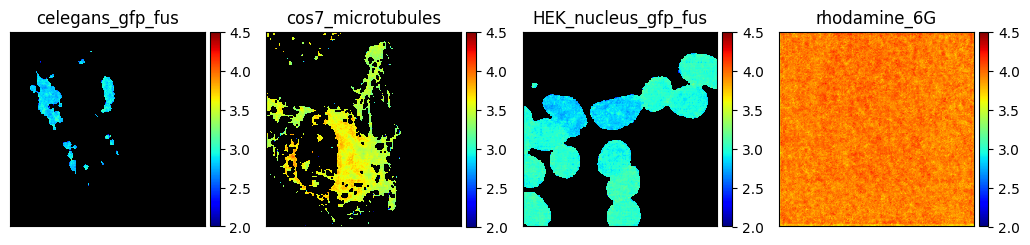

Predictions on 'reduced' photon count data


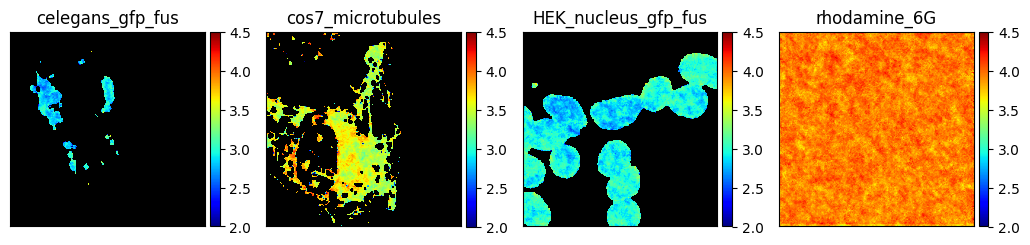

In [12]:
# store all model predictions in list
predicted_ls = [data['predicted_standard'] for data in data_dict.values() if 'predicted_standard' in data]
predicted_ls_rd = [data['prediction_reduced'] for data in data_dict.values() if 'prediction_reduced' in data]
# list of corresponding filenames
filenames_ls = [filename for filename, data in data_dict.items() if 'predicted_standard' in data]

vmin, vmax = 2, 4.5

print("Predictions on 'standard' photon count data")
visualise_images(predicted_ls, filenames_ls, cmap_c='jet', vmin=vmin, vmax=vmax, columns = 4, save_path=None)
print("Predictions on 'reduced' photon count data")
visualise_images(predicted_ls_rd, filenames_ls, cmap_c='jet', vmin=vmin, vmax=vmax, columns = 4, save_path=None)

In [13]:
# calculate Mean Squared Error (MSE)  between model standard and reduced photon count data
# dictionary to store the MSE for each file
mse_scores = {}

# iterate through data_dict
for filename, data in data_dict.items():
    if 'predicted_standard' in data and 'prediction_reduced' in data:
        # flatten arrays and replace any NaNs with zeros
        predicted = np.nan_to_num(data['predicted_standard'].flatten(), nan=0.0)
        ground_truth = np.nan_to_num(data['prediction_reduced'].flatten(), nan=0.0)

        # calculate MSE
        mse = mean_squared_error(ground_truth, predicted)

        # store the MSE in the dictionary
        mse_scores[filename] = mse

# print MSE scores for all files
print(f"MSE scores between 'standard' and 'reduced' photon count data")
for filename, mse in mse_scores.items():
    print(f"{filename}: {mse:.3f}")


MSE scores between 'standard' and 'reduced' photon count data
celegans_gfp_fus: 0.004
cos7_microtubules: 0.027
HEK_nucleus_gfp_fus: 0.010
rhodamine_6G: 0.012
